# 从零实现 Llama3 模型

> Note: 本文翻译自大佬的 [llama3-from-scratch](https://github.com/naklecha/llama3-from-scratch) 仓库，本人只是将英文翻译为中文，并无任何改动。原版英文：[README_en.md](README_en.md)。
>
> 如果对你有用麻烦点一下star，谢谢！

在这个文件中，从头实现了 Llama3，其中包含张量和矩阵乘法。

此外，直接从 Meta 提供的 Llama3 模型文件中加载张量，在运行此文件之前，需要下载权重。
这是官方链接： https://llama.meta.com/llama-downloads/

> 正在上传云盘，等待更新链接

<div>
    <img src="images/archi.png"/>
</div>

## tokenizer

不会实现一个 BPE 分词器（但 Andrej Karpathy 也有一个非常简洁的实现）

这是他的项目地址： https://github.com/karpathy/minbpe

<div>
    <img src="images/karpathyminbpe.png" width="600"/>
</div>


In [2]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

tokenizer_path = "Meta-Llama-3-8B-Instruct/tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

tokenizer.decode(tokenizer.encode("hello world!"))

'hello world!'

## 读取模型文件

通常，读取模型文件,往往取决于模型类的编写方式以及其中的变量名。

但由于要从零实现 Llama3，将一次性读取一个张量。


<div>
    <img src="images/model.png" width="600"/>
</div>

In [3]:
model = torch.load("Meta-Llama-3-8B-Instruct/consolidated.00.pth")
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [4]:
# 获取模型配置参数
with open("Meta-Llama-3-8B-Instruct/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

## 使用这些配置推理模型的细节

1. 模型有 32 个 Transformer 层
2. 每个多头注意力块有 32 个头
3. 词汇表大小等

In [5]:
# 从配置文件中提取模型参数
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

## 将文本转换为 token

这里使用 tiktoken（OpenAI 的库）作为分词器

<div>
    <img src="images/tokens.png" width="600"/>
</div>

In [6]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


## 将 token 转换为 embedding

这里使用内置的神经网络模块

无论如何, `[17x1]` token 现在是 `[17x4096]`，即每个 token 的长度为 4096 的 embeddings


注意：跟踪 shapes，这样一切将变得理解更容易

<div>
    <img src="images/embeddings.png" width="600"/>
</div>

In [7]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

## 接下来使用 RMS 归一化嵌入

请注意，经过此步骤后 shapes 不变， 只是值被归一化

需要注意的是，需要一个 norm_eps（来自配置）以避免不小心将 RMS 设置为 0 并导致除以 0 的情况

这是公式:

<div>
    <img src="images/rms.png" width="600"/>
</div>

In [8]:
# def rms_norm(tensor, norm_weights):
#     rms = (tensor.pow(2).mean(-1, keepdim=True) + norm_eps)**0.5
#     return tensor * (norm_weights / rms)

def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

# 构建第一个 Transformer 层


### 归一化

从模型字典中访问 `layer.0` （这是第一层）


归一化后 shapes 仍然是 `[17x4096]`， 与嵌入相同但已归一化

<div>
    <img src="images/norm.png" width="600"/>
</div>

In [9]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
token_embeddings.shape

torch.Size([17, 4096])

### 从头实现注意力机制

加载第一个 Transformer 层的注意力头

<div>
    <img src="images/qkv.png" width="600"/>
</div>

<br>

当我们从模型中加载 `query`， `key`，`value` 和 `output`  向量时，注意到 shapes 分别为 `[4096x4096]`， `[1024x4096]`， `[1024x4096]`， `[4096x4096]`

乍一看这有些奇怪，因为在理想情况下我们希望每个头单独拥有各自的 q，k，v 和 o

这里作者将其捆绑在一起，为什么会这样呢? 因为这样有助于并行化注意力头的计算

将展开所有内容...

In [10]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


### 展开 query

在下一节中，将展开多个注意力头的 query，得到的 shapes 为 `[32x128x4096]`


这里的 32 是 Llama3 的注意力头数量，128 是 query 向量的大小，4096 是 token 嵌入的大小

In [11]:
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
q_layer0.shape

torch.Size([32, 128, 4096])

### 实现第一层的第一个头

这里查询了第一个层的第一个头的 `query` 权重矩阵，其大小为 `[128x4096]`

In [12]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

### 现在将 query 权重与 token 嵌入相乘，以获得每个 token 的 query

这里可以看到得到的 shape 是 `[17x128]`， 这是因为有 17 个 token，每个 token 有一个长度为 128 的 query

<div>
    <img src="images/q_per_token.png" width="600"/>
</div>

In [13]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([17, 128])

## 位置编码

当前，每个 token 都有一个 query 向量，但如果你想一想 -- 其实各个 query 向量并不知道它们在 prompt 中的位置。

```text
query: "the answer to the ultimate question of life, the universe, and everything is "
```

在我示例 prompt 中，使用了三次 `"the"`，需要根据它们在 prompt 中的位置为每个 `"the"` token 生成不同的 `query` 向量（每个长度为128）。可以使用 RoPE（旋转位置编码）来实现这一点。

### RoPE
来看看这个视频(我就是看的这个)可以理解其中的数据学逻辑。
https://www.youtube.com/watch?v=o29P0Kpobz0&t=530s

> 等我传到B站，再更新链接


<div>
    <img src="images/rope.png" width="600"/>
</div>

In [14]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

这里为 prompt 中每个位置生成了旋转位置编码。可以看到，这些编码是正弦和余弦函数的组合。

在上的步骤里, 将 `query` 向量分成对, 并对每对应用旋转角度移位!


现在有一个大小为 `[17x64x2]` 的向量，这是针对 prompt 中的每个 token 将 128 个长度的 query 分为 64 对！ 这 64 对中的每一对都将旋转 `m*(theta)`，其中 `m` 是旋转查询的 token 的位置！


<div>
    <img src="images/qsplit.png" width="600"/>
</div>

## 使用复数点积计算旋转向量

<div>
    <img src="images/freq_cis.png" width="600"/>
</div>

In [15]:
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [16]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

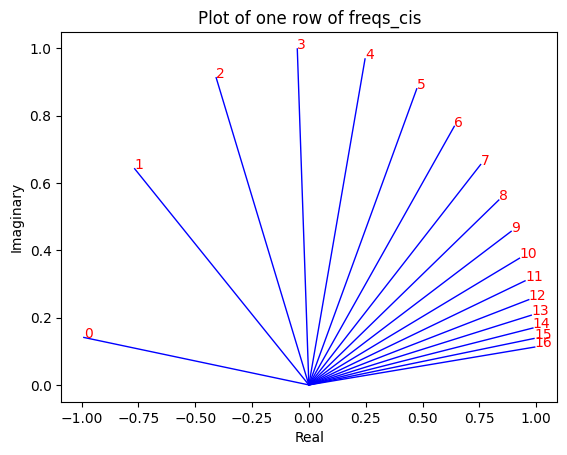

In [17]:
freqs_for_each_token = torch.outer(torch.arange(17), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# viewing tjhe third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

### 现在每个 token 的 query 元素都有一个复数（角度变化向量）

可以将 query（将其拆分成对）转换为复数，然后进行点积以根据位置旋转查询

In [18]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [19]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

torch.Size([17, 64])

### 得到旋转向量后

可以通过再次将复数看作实数来返回成对的 query

In [20]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

旋转对现在已合并，现在有了一个新的 query 向量（旋转 query 向量），其 shape 为 `[17x128]`，其中 17 是 token 的数量，128 是 query 向量的维度

In [21]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([17, 128])

# keys（几乎与 query 一模一样）

<div>
    <img src="images/keys.png" width="600px"/>
</div>

我是个懒鬼，所以不打算详细讲 keys 的数学过程，只需要记住以下几点：

- keys 生成的 key 向量的维度也是 128
- **keys 的权重只有 query 的 1/4，因为 keys 的权重在 4 个头之间共享，以减少计算量**
- keys 也像 query 一样被旋转以添加位置信息，其原因相同

In [22]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape

torch.Size([8, 128, 4096])

In [23]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [24]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([17, 128])

In [25]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [26]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [27]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [28]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([17, 128])

## 现在，已经有了每个 token 的旋转后的 query 和 key

<div>
    <img src="images/keys0.png" width="600px"/>
</div>

每个 query 和 key 的 shape 都是 `[17x128]`。

## 接下来，将 query 和 key 的矩阵相乘

这样做会得到每一个 token 相互映射的分数

这个分数描述了每个 token 的 query 与每个 token 的 key 的相关度。这就是自注意力 :)

注意力得分矩阵（qk_per_token）的 shape 是 `[17x17]`，其中 17 是 prompt 中的 token 数量

<div>
    <img src="images/qkmatmul.png" width="600px"/>
</div>

In [29]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([17, 17])

# 现在必须屏蔽 QK 分数

在 llama3 的训练过程中，未来的 token qk 分数被屏蔽。

为什么？因为在训练过程中，只学习使用过去的 token 来预测 token 。

因此，在推理过程中，将未来的 token 设置为零。

<div>
    <img src="images/mask.png" width="600px"/>
</div>

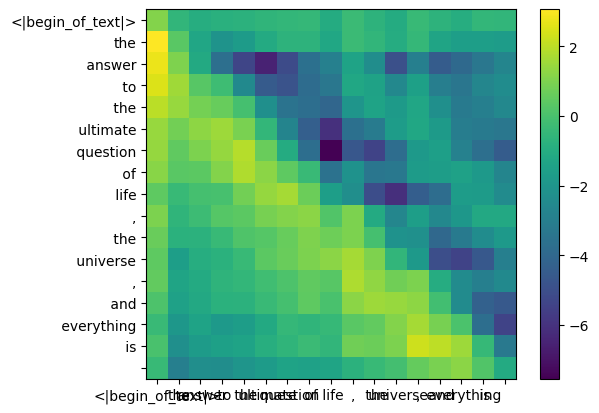

In [30]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [31]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

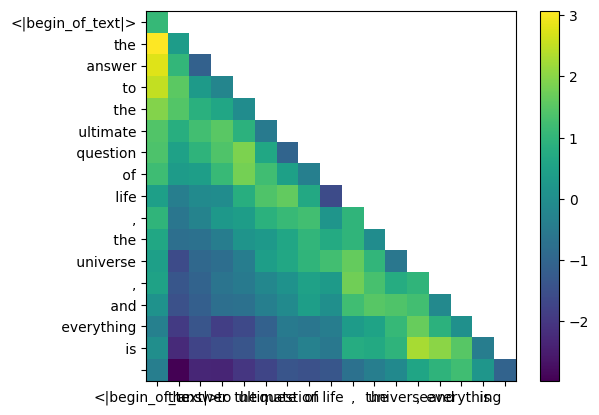

In [32]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

<div>
    <img src="images/softmax.png" width="600px"/>
</div>

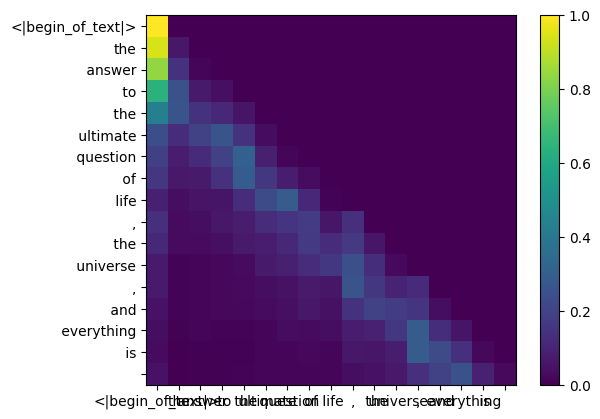

In [33]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

## values (注意力机制的最后部分) 

<div>
    <img src="images/value.png" width="600px"/>
</div>

这些分数（0-1）用于确定每个 token 中使用了多少 value 矩阵

> these scores (0-1) are used to determine how much of value matrix is used per token

和 key 一样，value 权重也在每 4 个注意力头之间进行共享（以节省计算量）

因此，下面的 value 权重矩阵的 shape 为 `[8x128x4096]`


In [34]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

torch.Size([8, 128, 4096])

the first layer, first head value weight matrix is given below

In [35]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

## value 向量

<div>
    <img src="images/v0.png" width="600px"/>
</div>

现在使用 value 权重来获取每个 token 的注意力值，其大小为 `[17x128]`，其中 17 是 prompt 中的 token 数，128 是每个 tokene 的 value 向量的维度

In [36]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([17, 128])

## 注意力(attention)

<div>
    <img src="images/attention.png" width="600px"/>
</div>

和每个 token 的 value 相乘后得到的注意力向量的 shape 为 `[17*128]`

In [37]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([17, 128])

# 多头注意力 (multi head attention)

<div>
    <img src="images/heads.png" width="600px"/>
</div>

现在已经有了第一层和第一个头的注意力值

现在将运行一个循环，并执行与上面单元格中相同的数学运算，但只针对第一层中的每个头

In [38]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

<div>
    <img src="images/stacked.png" width="600px"/>
</div>

现在有了第一个层的 32 个头的 qkv_attention 矩阵，接下来将把所有注意力分数合并成一个大矩阵，大小为 `[17x4096]`

In [39]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([17, 4096])

# 权重矩阵，最后几步之一

<div>
    <img src="images/weightmatrix.png" width="600px"/>
</div>

对于第0层，最后要做的一件事是，将权重矩阵相乘

In [40]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

### 这是一个简单的线性层，所以只需要进行乘法运算

In [41]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([17, 4096])

<div>
    <img src="images/afterattention.png" width="600px"/>
</div>

注意之后，现在有了嵌入值的变化，应该将其添加到原始的 token embeddings 中

In [42]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([17, 4096])

## 将其归一化，然后运行一个前馈神经网络

<div>
    <img src="images/norm_after.png" width="600px"/>
</div>

In [43]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
embedding_after_edit_normalized.shape

torch.Size([17, 4096])

## 加载 FFN 权重并实现前馈网络

<div>
    <img src="images/swiglu.png" width="600px"/>
</div>

在 llama3 中，使用了 `SwiGLU` 前馈网络，这种网络架构非常擅长非线性计算。

如今，在 LLMS 中使用这种前馈网络架构是相当常见的

In [44]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([17, 4096])

# 在第一层之后，终于为每个 token 编辑了新的 EMBEDDINGS

离结束还剩 31 层（一层 for 循环）

可以将经过编辑的 embedding 想象为包含有关第一层上提出的所有 query 的信息

现在，对所有提出的问题每一层都会对 query 进行越来越复杂的编码，直到得到一个 embedding，其中包含了需要的下一个 token 的所有信息。

In [45]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([17, 4096])

# 整合

<div>
    <img src="images/god.png" width="600px"/>
</div>

就是这样。 之前为每一层所做的一切都需要一次性完成。

In [46]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

# 得到最终 Embedding，对下一个 token 做预测

embedding 的 shape 与常规 token embedding shape `[17x4096]` 相同，其中 17 是 token 数量，4096 是 embedding 维度

<div>
    <img src="images/last_norm.png" width="600px"/>
</div>

In [47]:
final_embedding = rms_norm(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([17, 4096])

# 最后，将 embedding 解码为 token value

<div>
    <img src="images/finallayer.png" width="600px"/>
</div>

将使用输出解码器将最终 embedding 转换为 token。

In [48]:
model["output.weight"].shape

torch.Size([128256, 4096])

# 使用最后一个 token 的 embedding 来预测下一个值

希望在我们预料之内, 42 :)

注意：根据《银河系漫游指南》书中提到，“生命、宇宙和一切的终极问题的答案是 42 ” 。大多数现代语言模型在这里应该会回答 42，这应该能验证我们的整个代码！祝我好运 :)

In [49]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

### 模型预测的 token 编号是 2983，这是否代表 42 的 token 编号？

这已经是代码的最后一部分了，希望你已经信心满满 :)

In [50]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983)

# 解码

<div>
    <img src="images/42.png" width="600px"/>
</div>

In [51]:
tokenizer.decode([next_token.item()])

'42'

# 感恩, 爱你哟 :)

这就是结尾了。希望你喜欢！

如果你想支持我的工作：

1. 在 Twitter 上关注我：https://twitter.com/naklecha
2. 或者给我买杯咖啡：[https://www.buymeacoffee.com/naklecha](https://www.buymeacoffee.com/naklecha)

说实话，如果你能到这一步，已经让我很开心了:)